In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c

from axiprop.lib import PropagatorSymmetric
from axiprop.utils import *

## Laser and parabolic mirror parameters

In [2]:
lambda0 = 0.8e-6           # wavelength [m]
tau_fwhm = 35e-15          # FWHM duration (intensity) [s]
R_las = 10e-3              # Radial size of laser [m]

tau = tau_fwhm / (2*np.log(2))**0.5
k0 = 2 * np.pi / lambda0

def fu_laser(kz, r):
    """
    Gaussian spot with the Gaussian temporal profile
    """
    profile_r = np.exp( -(r/R_las)**2 ) * (r<3.5*R_las)
    profile_kz = np.exp( -( (kz-k0) * c * tau / 2 )**2 )
    return profile_r * profile_kz

f_N = 40                 # f-number of the parabolic mirror
f0 = 2 * R_las * f_N     # focal length

## Simulation domain and propagator

In [3]:
L_kz = 8 / (c*tau)                 # full spectral width [1/s] 
Nkz = 1                      # number of kz modes

w0 = 2/np.pi * lambda0 * f_N   # beam waist
L_R = np.pi * w0**2/lambda0    # Rayleigh length
dr = w0/16                      # estimate grid resolution

Rmax = 2.5 * R_las            # total radius [m]
Nr = int( Rmax / dr )         # total radial grid number
Nr_end = int( 12*w0 / dr)       # radial grid number around focus

prop = PropagatorSymmetric(Rmax, L_kz, Nr, Nkz, k0,  Nr_end)

## Create laser, reflect it from mirror and propagate to focus

In [4]:
A0 = fu_laser(prop.kz[:,None], prop.r[None,:])
A0 = A0 * mirror_parabolic(f0, prop.r, prop.kz )
A0 /= np.abs(A0[:,:]**2).sum(0).max()**.5 * (R_las/w0) # normalise amplitude (a.u)
A0 = prop.step(A0, f0)

<IPython.core.display.Javascript object>


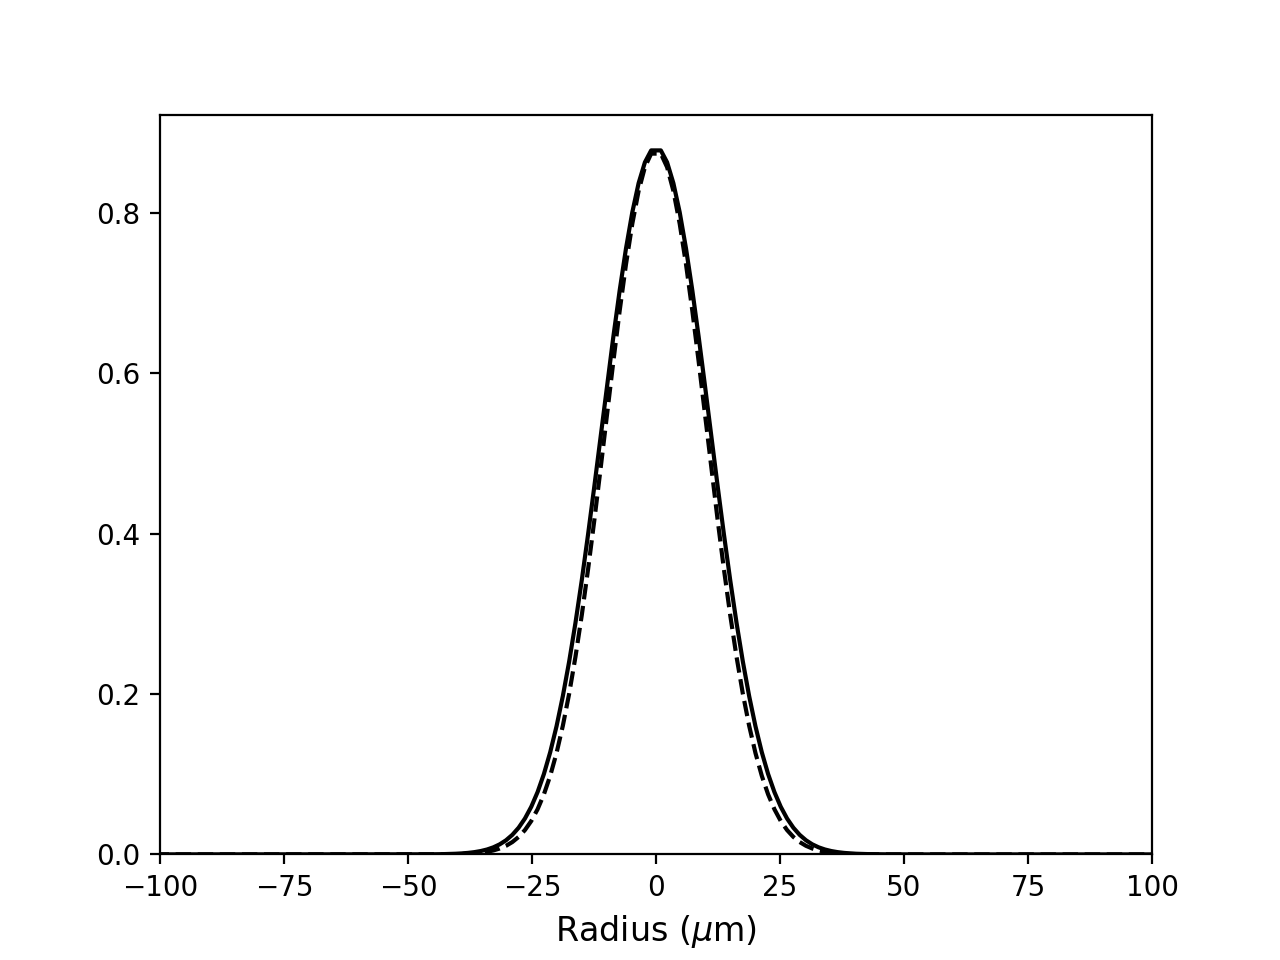

In [5]:
val = np.abs(A0**2).sum(0)
val = np.r_[val[::-1], val]
coord = np.r_[-prop.r_new[::-1], prop.r_new]

plt.figure()
plt.plot(coord*1e6, val, c='k', lw=1.5)
plt.plot(coord*1e6, val.max()*np.exp(-2*(coord/w0)**2), '--', c='k')

plt.xlim(-100,100)
plt.ylim(0,)

plt.xlabel('Radius ($\mu$m)', fontsize=12);

## Create laser, reflect it from mirror and propagate around the focus

In [6]:
A0 = fu_laser(prop.kz[:,None], prop.r[None,:])
A0 = A0 * mirror_parabolic(f0, prop.r, prop.kz )
A0 /= np.abs(A0[:,:]**2).sum(0).max()**.5 * (R_las/w0) # normalise amplitude (a.u)

dz = 8 * L_R / 80
zsteps = 80 * [dz,]
zsteps[0] = f0 - 4*L_R 

A_multi = prop.steps(A0, zsteps)

Propagating:


<IPython.core.display.Javascript object>


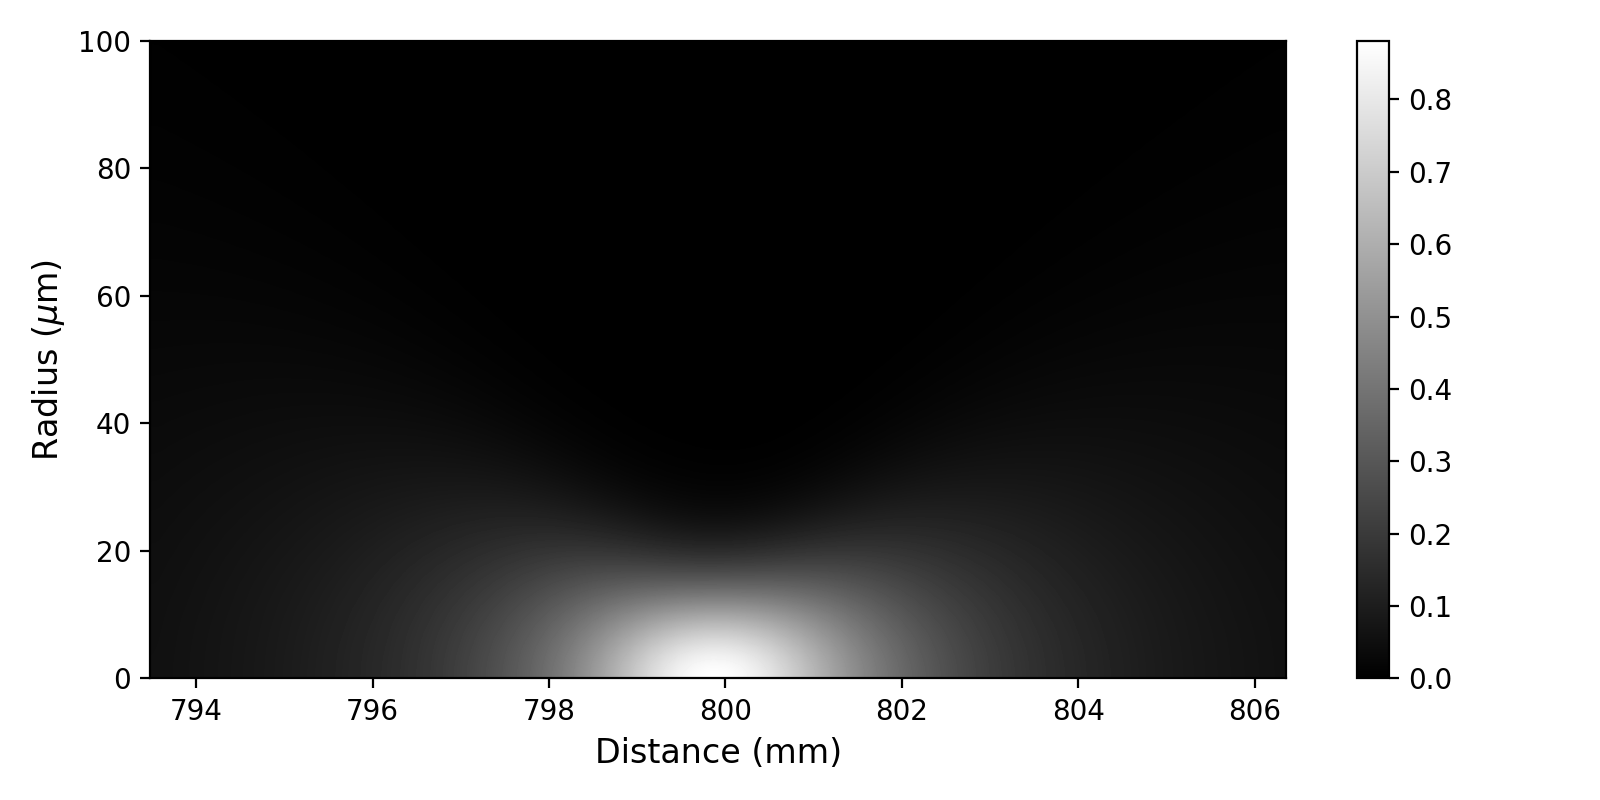

In [7]:
InetsityPropagation = []
for istep in range(A_multi.shape[-1]):
    val = np.abs(A_multi[:,:,istep]**2).sum(0)
    InetsityPropagation.append(val)
    
InetsityPropagation = np.array(InetsityPropagation)


plt.figure(figsize=(8,4), tight_layout=True)

plt.imshow(InetsityPropagation.T, 
           extent=[ zsteps[0]*1e3, sum(zsteps)*1e3, 0, prop.r_new.max()*1e6 ],
           aspect='auto', origin='lower', interpolation='gaussian',
           cmap=plt.cm.gray
          )
plt.ylim(0, 100);
plt.colorbar();

plt.xlabel('Distance (mm)', fontsize=12)
plt.ylabel('Radius ($\mu$m)', fontsize=12);